# **Setup**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
import pathlib

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#**Connect to dogs Google Drive folder**

In [3]:
proj_path = 'gdrive/My Drive/dogs'
data_dir = pathlib.Path(proj_path)
print(len(list(data_dir.glob('*/*'))))

1737


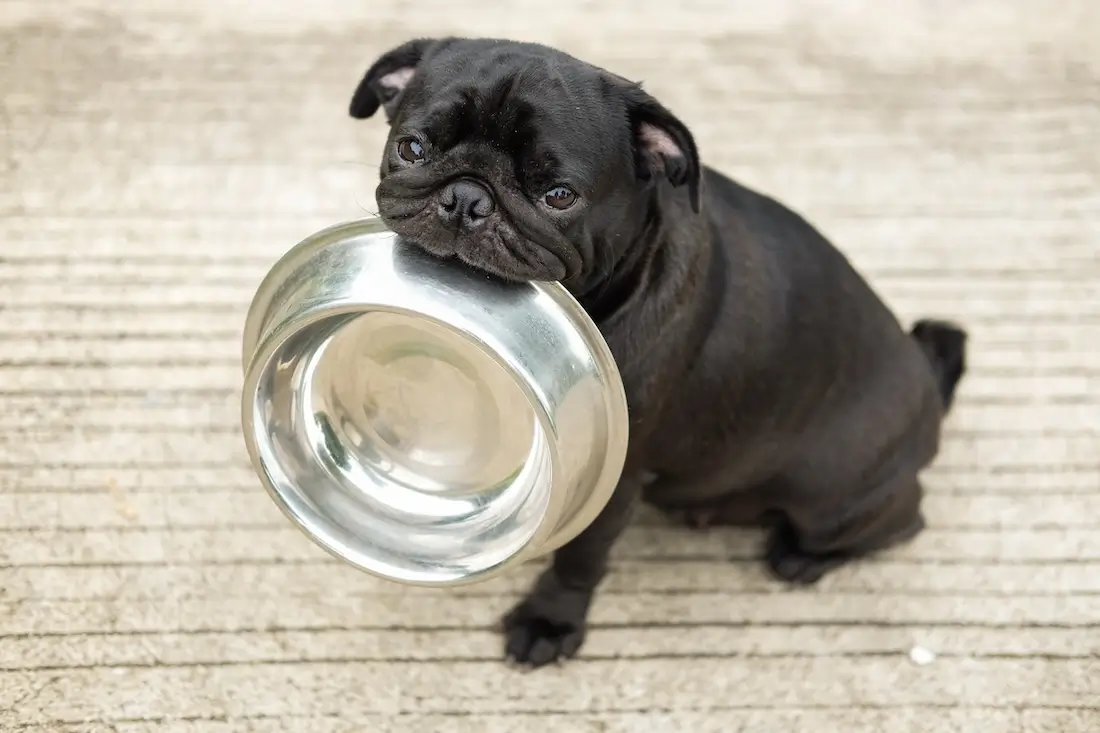

In [4]:
pugs = list(data_dir.glob('pug/*'))
PIL.Image.open(str(pugs[0]))

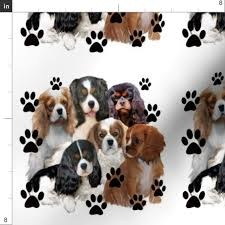

In [5]:
cavaliers = list(data_dir.glob('cavalier/*'))
PIL.Image.open(str(cavaliers[0]))

# **Specify training and validation photos**

In [6]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1736 files belonging to 5 classes.
Using 1389 files for training.
Found 1736 files belonging to 5 classes.
Using 347 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['cavalier', 'chihuahua', 'labrador', 'pug', 'rottweiler']


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Data Augmentation Techniques**

In [10]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# **Build and train the model**

In [17]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


In [18]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
44/44 [==============================] - 10s 46ms/step - loss: 1.6161 - accuracy: 0.3117 - val_loss: 1.5279 - val_accuracy: 0.3775
Epoch 2/30
44/44 [==============================] - 1s 17ms/step - loss: 1.4616 - accuracy: 0.3967 - val_loss: 1.4527 - val_accuracy: 0.4409
Epoch 3/30
44/44 [==============================] - 1s 17ms/step - loss: 1.3997 - accuracy: 0.4233 - val_loss: 1.3912 - val_accuracy: 0.4150
Epoch 4/30
44/44 [==============================] - 1s 17ms/step - loss: 1.3745 - accuracy: 0.4255 - val_loss: 1.4172 - val_accuracy: 0.4179
Epoch 5/30
44/44 [==============================] - 1s 18ms/step - loss: 1.3147 - accuracy: 0.4557 - val_loss: 1.3305 - val_accuracy: 0.4841
Epoch 6/30
44/44 [==============================] - 1s 17ms/step - loss: 1.2740 - accuracy: 0.4845 - val_loss: 1.3060 - val_accuracy: 0.4553
Epoch 7/30
44/44 [==============================] - 1s 17ms/step - loss: 1.2070 - accuracy: 0.5047 - val_loss: 1.1733 - val_accuracy: 0.5014
Epoch 8/30
4

# **Plot model performance over trianing epochs**

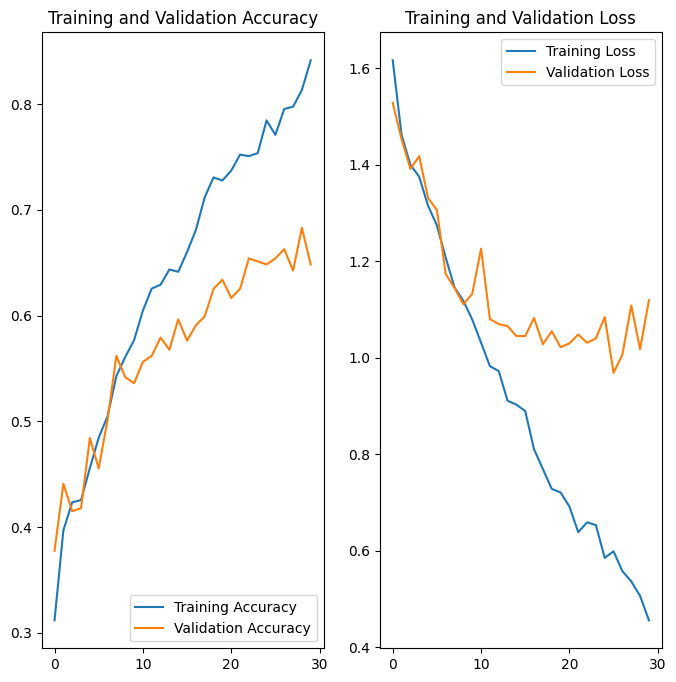

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Prediction time!**

1/1 [==============================] - 0s 251ms/step
This image most likely belongs to pug with a 99.74 percent confidence.


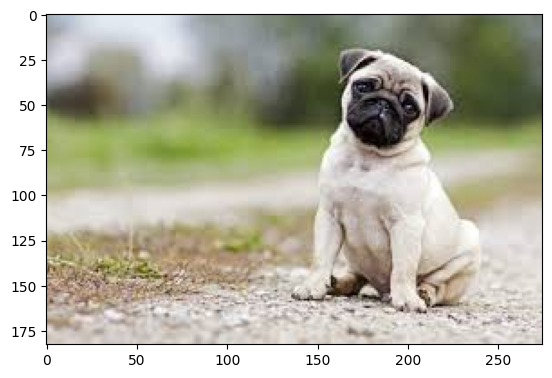

In [22]:
img_path = 'gdrive/My Drive/test_dogs/cute_pug.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
img = np.asarray(PIL.Image.open(img_path))
plt.imshow(img)
plt.show()

1/1 [==============================] - 0s 22ms/step
This image most likely belongs to cavalier with a 100.00 percent confidence.


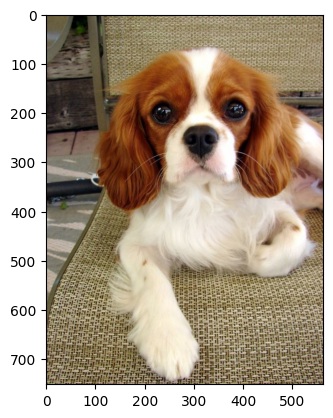

In [23]:
img_path = 'gdrive/My Drive/test_dogs/cute_cavalier.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
img = np.asarray(PIL.Image.open(img_path))
plt.imshow(img)
plt.show()

1/1 [==============================] - 0s 22ms/step
This image most likely belongs to rottweiler with a 53.95 percent confidence.


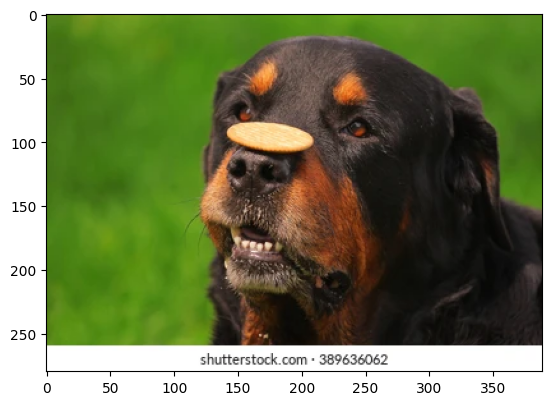

In [25]:
img_path = 'gdrive/My Drive/test_dogs/cute_rottweiler.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
img = np.asarray(PIL.Image.open(img_path))
plt.imshow(img)
plt.show()